### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [5]:
data = read_text("gdrive/My Drive/Colab Notebooks/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [7]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It gave me the creeps.', 'Ich bekam davon Gänsehaut.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #42354 (CK) & #2143533 (Tamy)'],
       ['It happened in Boston.', 'Es ist in Boston passiert.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6845115 (CK) & #7482756 (Luiaard)'],
       ['It happened last year.', 'Es passierte letztes Jahr.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5751805 (Catriona) & #5751840 (wolfgangth)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It gave me the creeps', 'Ich bekam davon Gänsehaut',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #42354 (CK) & #2143533 (Tamy)'],
       ['It happened in Boston', 'Es ist in Boston passiert',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6845115 (CK) & #7482756 (Luiaard)'],
       ['It happened last year', 'Es passierte letztes Jahr',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5751805 (Catriona) & #5751840 (wolfgangth)']],
      dtype='<U537')

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['it gave me the creeps', 'ich bekam davon gänsehaut',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #42354 (CK) & #2143533 (Tamy)'],
       ['it happened in boston', 'es ist in boston passiert',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6845115 (CK) & #7482756 (Luiaard)'],
       ['it happened last year', 'es passierte letztes jahr',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5751805 (Catriona) & #5751840 (wolfgangth)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

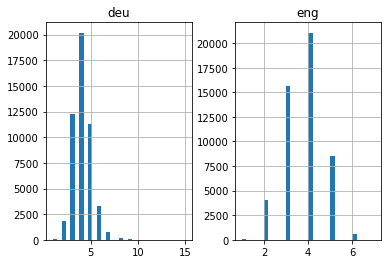

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6238


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10336


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [15]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [16]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10326


In [17]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6241


It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [18]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [19]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [20]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [21]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [22]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4143
Epoch 00001: val_loss improved from inf to 2.84308, saving model to model.h1.24_jan_19
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 22s 351ms/step - loss: 3.4143 - val_loss: 2.8431
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7669
Epoch 00002: val_loss improved from 2.84308 to 2.71658, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 21s 331ms/step - loss: 2.7669 - val_loss: 2.7166
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.5883
Epoch 00003: val_loss improved from 2.71658 to 2.54598, savin

Let's compare the training loss and the validation loss.

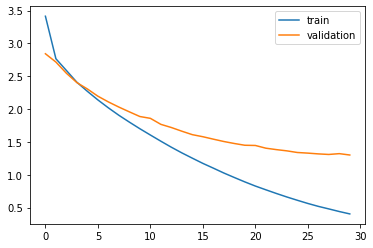

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [24]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [27]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [28]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [29]:
pd.set_option('display.max_colwidth', 200)

In [30]:
pred_df.head(15)

,actual,predicted
0,i said good morning,i slept a night
1,write tom,hug tom
2,dogs are smart,dogs are
3,was tom right,was tom was
4,they are my brothers,these are my
5,i am telling a story,i see a
6,well give it a shot,well try to
7,ill try to be early,ill buy some a
8,schools not fun,this isnt from
9,its not always easy,its not


In [31]:
pred_df.tail(15)

,actual,predicted
9985,this is all on me,i crossed the bill
9986,did you ever try,did you ever it yet
9987,i know tom is fast,i know tom is a
9988,where did i put it,where did i put it
9989,i was helping tom,i helped tom
9990,tom seems excited,tom seems busy
9991,i wont tell you,i wont tell you
9992,whos sick,who rich
9993,the auction is over,the partys over
9994,now we know why,we know why


In [32]:
pred_df.tail(15)

,actual,predicted
9985,this is all on me,i crossed the bill
9986,did you ever try,did you ever it yet
9987,i know tom is fast,i know tom is a
9988,where did i put it,where did i put it
9989,i was helping tom,i helped tom
9990,tom seems excited,tom seems busy
9991,i wont tell you,i wont tell you
9992,whos sick,who rich
9993,the auction is over,the partys over
9994,now we know why,we know why


In [33]:
pred_df.sample(15)

,actual,predicted
6449,i feel very good,i feel great
2290,i forget her name,im not
4614,that is intriguing,that is
3099,you must not smoke,you must not smoke
1083,tom has lung cancer,tom has mute
8839,dont be a baby,dont pick your legs
5081,i wont tell tom,i wont tell tom
4236,people love freedom,this was got sense
2220,i know tom is deaf,i know tom is
8458,is this your letter,is this your yours
